## Reading the secrets and importing the requirements

In [5]:
from secrets_import import * # check the secrets_import file for details

In [1]:
from config_setup_helper import * # check the config_setup file for details

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import time
from datetime import datetime,UTC
from bs4 import BeautifulSoup
import re
import pytesseract
from PIL import Image
import requests
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec
import pymysql
import numpy as np

## Scraping and cleaning helpers

In [3]:
# Load stopwords for keyword extraction
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Remove HTML, special characters, ads, and extra spaces."""
    if not text:
        return ""  # Handle empty text cases

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters, links, and promoted messages
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase

    # Mask usernames
    text = re.sub(r'u/[A-Za-z0-9_-]+', '[USERNAME]', text)
    
    # remove stopwords
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    return text

def extract_keywords(text):
    """Extract important keywords from the post content."""
    words = word_tokenize(text)
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    return ', '.join(set(keywords))  # Convert list to string for storage

def extract_text_from_images(image_url):
    """Extract text from images using OCR (Pytesseract)."""
    try:
        # Download the image (placeholder, needs proper downloading logic)
        requests.get(image_url, stream=True).raw
        image = Image.open(requests.get(image_url, stream=True).raw)  # This assumes the image is already downloaded
        text = pytesseract.image_to_string(image)
        return clean_text(text)
    except Exception as e:
        print(f"Could not process image {image_url}: {e}")
        return ""


## Code to pull and save the posts in DB

In [4]:
def fetch_and_store_reddit_posts(subreddit_name, n_posts):
    """Fetch, preprocess, and store Reddit posts while handling large requests."""
    setup_database()

    subreddit = reddit.subreddit(subreddit_name)
    batch_size = 1000  # Max Reddit API limit per request
    fetched_posts = 0
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, database = MYSQL_DB)
    cursor = conn.cursor()

    while fetched_posts < n_posts:
        limit = min(batch_size, n_posts - fetched_posts)

        print(f"Fetching {limit} posts...")

        try:
            for post in subreddit.hot(limit=limit):
                title = post.title
                content = clean_text(post.selftext) 
                
                timestamp = datetime.fromtimestamp(post.created_utc, UTC)
                
                image_text = ""
                if hasattr(post, "preview") and "images" in post.preview:
                    image_url = post.preview["images"][0]["source"]["url"]
                    image_text = extract_text_from_images(image_url)
                    
                    
                if not content and not image_text:
                    continue
                
                keywords = extract_keywords(title+" "+content+" "+image_text)  # Extract keywords

                # Store in MySQL
                sql = "INSERT INTO posts (title, content, timestamp, subreddit, keywords, image_text) VALUES (%s, %s, %s, %s, %s, %s)"
                cursor.execute(sql, (title, content, timestamp, subreddit_name, keywords, image_text))

                fetched_posts += 1
                if fetched_posts >= n_posts:
                    break  # Stop when we reach desired count

            conn.commit()
            print(f"Stored {fetched_posts} posts so far.")

        except Exception as e:
            print(f"Error fetching posts: {e}")
            time.sleep(5)  # Retry after a short delay

        time.sleep(2)  # Avoid rate limits

    print(f"Successfully stored {fetched_posts} posts.")
    conn.close()

### Calling the function (run all above cells first)

In [6]:
if __name__ == "__main__":
    fetch_and_store_reddit_posts("askscience", 20)

Database and table setup complete.


KeyboardInterrupt: 

## Generating Embeddings

#### Using both doc2vec and word2 vec to generate 2 seperate embeddings

In [6]:
import pymysql

def get_posts():
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, db=MYSQL_DB)
    cursor = conn.cursor()
    cursor.execute("SELECT id, title, content, image_text FROM posts")
    posts = cursor.fetchall()
    conn.close()
    return posts

posts = get_posts()
print(posts)

((1, 'AskScience Panel of Scientists XXVII', 'please read entire post carefully format application appropriately post new panelist recruitment previous one panel informal group redditors either professional scientists training become panelists least graduate level familiarity within declared field expertise answer questions related areas study panelist expertise summarized color coded askscience flair membership panel comes access panelist subreddit place panelists interact voice concerns moderators moderators make announcements whole panel good place network people share interests eligible join panel studying least msc equivalent degree sciences able communicate knowledge field level accessible various audiences instructions formatting panelist application choose exactly one general field side bar physics engineering social sciences etc state specific field one word phrase neuropathology quantum chemistry etc succinctly describe particular area research words carbon nanotube dielectri

### Embeddings based on Doc2Vec

In [7]:
def doc2Vec_embeddings(posts):
    tagged_data = [
        TaggedDocument(
            words=word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))),
            tags=[str(row[0])]
        )
        for row in posts
    ]

    model_doc = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=20)
    model_doc.build_vocab(tagged_data)

    model_doc.train(tagged_data, total_examples=model_doc.corpus_count, epochs=model_doc.epochs)

    vectors_doc = []
    for row in posts:
        vectors_doc.append(model_doc.infer_vector(word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]])))))

def doc2Vec_experiment(posts, vector_size, epochs, min_count):
    tagged_data = [
        TaggedDocument(
            words=word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))),
            tags=[str(row[0])]
        )
        for row in posts
    ]

    model_doc = Doc2Vec(vector_size=vector_size, window=5, min_count=min_count, workers=4, epochs=epochs)
    model_doc.build_vocab(tagged_data)

    model_doc.train(tagged_data, total_examples=model_doc.corpus_count, epochs=model_doc.epochs)

    return model_doc

model1 = doc2Vec_experiment(posts, vector_size=50, epochs=20, min_count=2)
model2 = doc2Vec_experiment(posts, vector_size=100, epochs=30, min_count=5)
model3 = doc2Vec_experiment(posts, vector_size=200, epochs=40, min_count=10)

doc2vec_vectors = np.array([model1.infer_vector(word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]])))) for row in posts])

### Embeddings based on Word2Vec and Bag-of-Words

In [8]:
def word2Vec_embeddings(posts):
    tokenized_posts = [word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))) for row in posts]
    model = Word2Vec(sentences=tokenized_posts, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

def word2vec_training(posts, vector_size=100):
    sentences = [word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))) for row in posts]
    model_word = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=2, workers=4)
    return model_word

model_word = word2vec_training(posts, vector_size=100)

In [9]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(sentences=[word_tokenize(clean_text(" ".join([str(x) for x in row[1:]]))) for row in posts],
                          vector_size=100, window=5, min_count=2, workers=4)

word2vec_vectors = np.array([
    np.mean([word2vec_model.wv[word] for word in word_tokenize(clean_text(" ".join([str(x) for x in row[1:]]))) if word in word2vec_model.wv], axis=0)
    for row in posts
])

In [24]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_documents(vectors, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectors)
    return labels

labels_doc2vec = cluster_documents([model1.infer_vector([str(word) for word in doc]) for doc in posts])

labels_word2vec = cluster_documents(
    [model_word.wv[str(doc[0])] for doc in posts if str(doc[0]) in model_word.wv]
)

print("Doc2Vec Clusters:", labels_doc2vec)
print("Word2Vec Clusters:", labels_word2vec)

Doc2Vec Clusters: [1 1 1 ... 4 2 0]
Word2Vec Clusters: [2 2 2 2 1 1 3 3 1 1 1 1 3 3 1 4 3 4 3 1 0 0 0 3 3 4 0 0 0 1 0 3 0 1 0 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 3 0 0 0 3 3 0 0 3 3 0 3 0 0 0 0 0
 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0
 3 3 4 0 0 0 0 0 0 0 0 0 0]


In [26]:
labels_doc2vec.shape

(5040,)

### Bag-of-Words by using CountVectorizer

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

vectorizer = CountVectorizer()
bow_vectors = vectorizer.fit_transform([
    " ".join(word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))))
    for row in posts
])

def cluster_documents(vectors, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectors)
    return labels

labels_bow = cluster_documents(bow_vectors.toarray())
print("BoW Clusters:", labels_bow)

BoW Clusters: [1 1 1 ... 1 1 1]


## Evaluation metrics (quantitave and qualitative) to make comparisions:

NOTE: in report we should mention these below + manually inspect the clusters by checking if grouped documents are thematically similar and use that for the qualitative part too, and write an explanation of which method created more meaningful clusters.

Cluster Separation
Good clustering: Well-separated, distinct clusters with clear boundaries.
Poor clustering: Overlapping or mixed clusters (indicates embeddings may not capture differences well).
Cluster Shape & Compactness
Tightly packed clusters: Indicate strong embedding quality.
Scattered, stretched, or elongated clusters: Suggest embeddings may not be well-formed.
Outliers
Isolated points far from any cluster may indicate noisy or misclassified data.
Comparison Between Doc2Vec & Word2Vec
Which method produces better-separated clusters?
Does one have less overlap and more distinct groups?

In [29]:
#quantitative: silhouette score
#measures how well samples are clustered (higher is better)

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

vectors_doc = [model1.infer_vector([str(word) for word in doc]) for doc in posts]
cluster_doc = cluster_documents(vectors_doc, n_clusters=5)


vectors_word =  [model_word.wv[str(doc[0])] for doc in posts if str(doc[0]) in model_word.wv]
clusters_word = cluster_documents(
    [model_word.wv[str(doc[0])] for doc in posts if str(doc[0]) in model_word.wv]
)

# Silhouette Score for Doc2Vec clusters
doc2vec_silhouette = silhouette_score(vectors_doc, cluster_doc)
print(f"Silhouette Score for Doc2Vec: {doc2vec_silhouette:.4f}")

# Silhouette Score for Word2Vec clusters
word2vec_silhouette = silhouette_score(vectors_word, clusters_word)
print(f"Silhouette Score for Word2Vec: {word2vec_silhouette:.4f}")

# Silhouette Score for BoW clusters
silhouette_score_bow = silhouette_score(bow_vectors.toarray(), labels_bow)
print("Silhouette Score for BoW:", silhouette_score_bow)

Silhouette Score for Doc2Vec: 0.0185
Silhouette Score for Word2Vec: 0.4737
Silhouette Score for BoW: 0.19297678973879828


In [30]:
#quantitative: Davies-Bouldin Index
#lowe bdi value means cluster better defined, high means more overlap

from sklearn.metrics import davies_bouldin_score

# Davies-Bouldin Index for Doc2Vec clusters
doc2vec_dbi = davies_bouldin_score(vectors_doc, cluster_doc)
print(f"Davies-Bouldin Index for Doc2Vec: {doc2vec_dbi:.4f}")

# Davies-Bouldin Index for Word2Vec clusters
word2vec_dbi = davies_bouldin_score(vectors_word, clusters_word)
print(f"Davies-Bouldin Index for Word2Vec: {word2vec_dbi:.4f}")

# Davies-Bouldin Index for BoW clusters
davies_bouldin_bow = davies_bouldin_score(bow_vectors.toarray(), labels_bow)
print("Davies-Bouldin Index for BoW:", davies_bouldin_bow)

Davies-Bouldin Index for Doc2Vec: 4.6840
Davies-Bouldin Index for Word2Vec: 1.1255
Davies-Bouldin Index for BoW: 0.5697218253102105


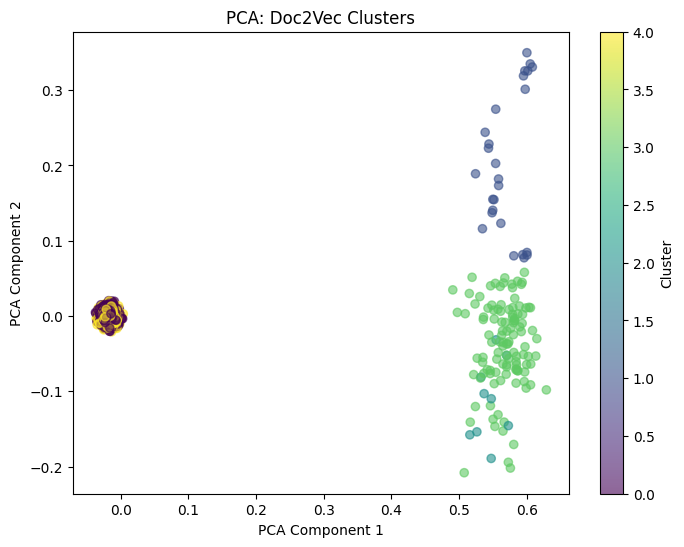

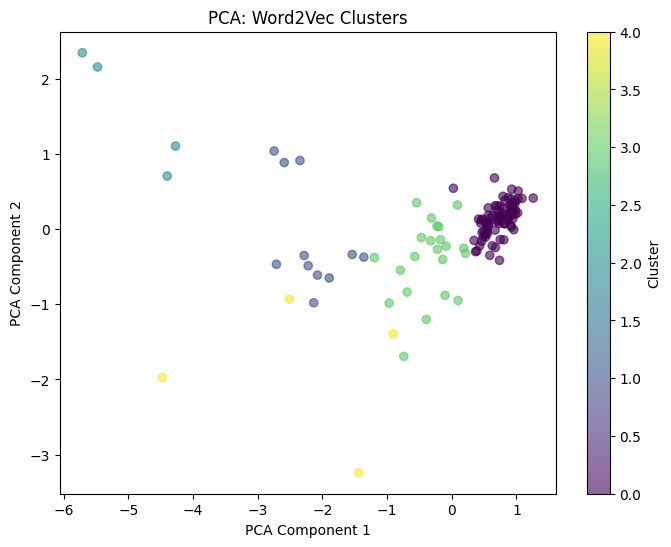

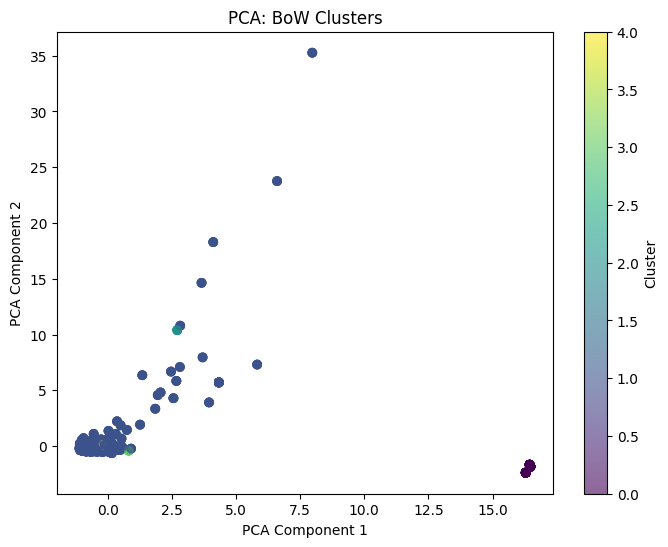

In [31]:
#PCA (Principal Component Analysis)
#helps visualize separation between clusters

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(embeddings, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label="Cluster")
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# PCA Visualization for Doc2Vec
plot_pca(vectors_doc, cluster_doc, "PCA: Doc2Vec Clusters")

# PCA Visualization for Word2Vec
plot_pca(vectors_word, clusters_word, "PCA: Word2Vec Clusters")

# PCA Visualization for BoW
plot_pca(bow_vectors.toarray(), labels_bow, "PCA: BoW Clusters")

In [34]:
doc2vec_vectors.shape

(5040, 50)

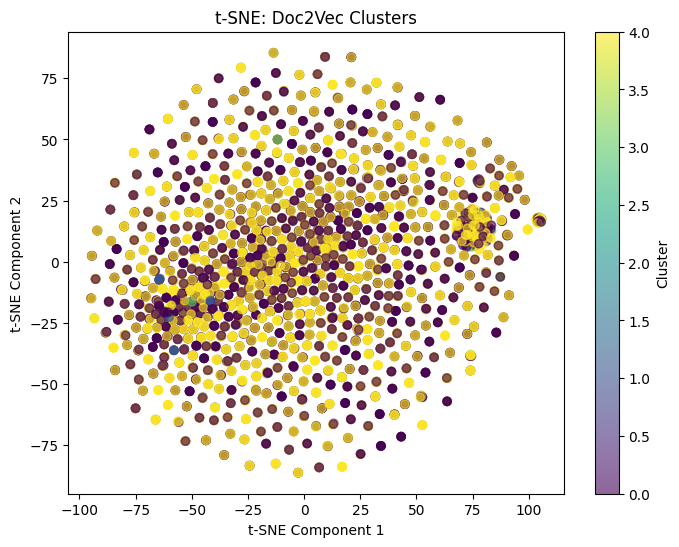

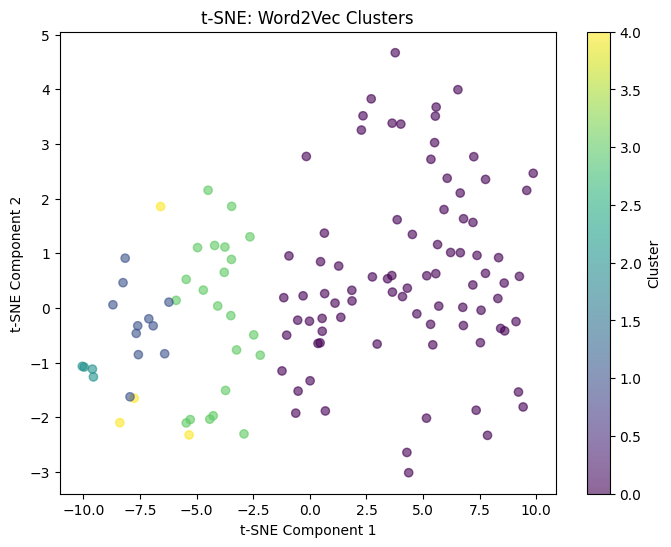

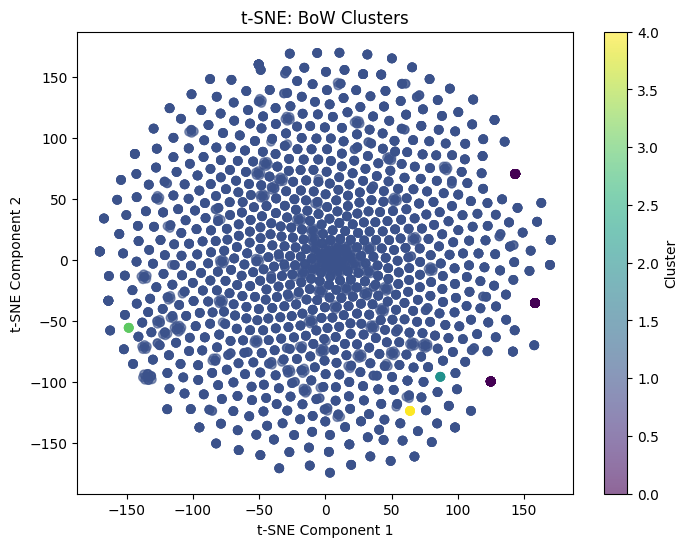

In [39]:
#t-SNE (t-Distributed Stochastic Neighbor Embedding)
#t-SNE helps visualize complex relationships in high-dimensional data

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(embeddings, labels, title):
    perplexity_value = min(30, len(embeddings) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label="Cluster")
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# Visualize t-SNE for Doc2Vec
plot_tsne(doc2vec_vectors, cluster_doc, "t-SNE: Doc2Vec Clusters")

# Visualize t-SNE for Word2Vec
plot_tsne(np.array(vectors_word), clusters_word, "t-SNE: Word2Vec Clusters")

# Visualize t-SNE for BoW
plot_tsne(bow_vectors.toarray(), labels_bow, "t-SNE: BoW Clusters")
